In [1]:
### automatically refresh the buffer

%load_ext autoreload
%autoreload 2

### solve the auto-complete issue

%config Completer.use_jedi = False

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### lvl 2 setups (systerm)

import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
warnings.filterwarnings('ignore')
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Wedge, Circle
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime
import datetime

In [2]:
clist1 =['#7cb3d4','#669dc7','#5185bb','#426cae','#3951a0','#303692',
        '#a60025','#bb1624','#d12927','#e14230','#ed5c3d','#f6774b',
        '#fa9359','#fdaf67','#fdc77c','#ffdc8f','#feeaa5','#fff8b7',
        '#f8fccd','#ebf7e4','#dcf1f7','#c4e6f0','#aadae8','#94c6de',]
red1 = LinearSegmentedColormap.from_list('chaos',clist1,N=24)
dpi_ = 300

In [3]:
gdf = gpd.read_file('../../tl_2019_us_state/tl_2019_us_state.shp')
US = gpd.read_file('../../tl_2019_us_state/tl_2019_us_state.shp')
output_folder = '/N/project/Zli_lab/gongg/CONUS404_data/LST/JJA/'

In [4]:
ds_tmin = xr.open_mfdataset(output_folder+'temp_min*.nc')
ds_tmean = xr.open_mfdataset(output_folder+'temp_mean*.nc')
ds_dtmin = xr.open_mfdataset(output_folder+'dtemp_min*.nc')
ds_dtmean = xr.open_mfdataset(output_folder+'dtemp_mean*.nc')

In [17]:
ds_dt_tmin = xr.open_mfdataset(output_folder+'daytime_temp_min*.nc')
ds_dt_tmean = xr.open_mfdataset(output_folder+'daytime_temp_mean*.nc')
ds_dt_dtmin = xr.open_mfdataset(output_folder+'daytime_dtemp_min*.nc')
ds_dt_dtmean = xr.open_mfdataset(output_folder+'daytime_dtemp_mean*.nc')

In [5]:
ds_raster = xr.open_dataset('/N/project/Zli_lab/Data/Observations/NCAR/prec_acc_files/PREC_ACC_NC.wrf2d_d01_2022-09-30_23:00:00.nc')

In [6]:
lon = ds_raster['XLONG'].values
lat = ds_raster['XLAT'].values
grid = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(lon.flatten(), lat.flatten()),
    index=np.arange(lon.size)
)
grid.set_crs(gdf.crs, inplace=True)
grid_s = gpd.sjoin(grid, gdf, how='inner', predicate='within')

mask = np.full(ds_raster['PREC_ACC_NC'].shape[1:], False) 
for index in grid_s.index:
    row, col = np.unravel_index(index, mask.shape)  # 获取行列索引
    mask[row, col] = True
mask_da = xr.DataArray(mask, dims=ds_raster['PREC_ACC_NC'].dims[1:], coords={'south_north': ds_raster['PREC_ACC_NC'].coords['south_north'], 'west_east': ds_raster['PREC_ACC_NC'].coords['west_east']})
ds_conus = ds_raster.where(mask_da, drop=True)

In [18]:
XLON = ds_conus.XLONG.values[:707,:]
XLAT = ds_conus.XLAT.values[:707,:]
ds_tmin2 = ds_tmin.assign_coords({'XLON': (('lat', 'lon'), XLON),'XLAT': (('lat', 'lon'), XLAT)})
ds_tmean2 = ds_tmean.assign_coords({'XLON': (('lat', 'lon'), XLON),'XLAT': (('lat', 'lon'), XLAT)})
ds_dtmin2 = ds_dtmin.assign_coords({'XLON': (('lat', 'lon'), XLON),'XLAT': (('lat', 'lon'), XLAT)})
ds_dtmean2 = ds_dtmean.assign_coords({'XLON': (('lat', 'lon'), XLON),'XLAT': (('lat', 'lon'), XLAT)})

ds_dt_tmin2 = ds_dt_tmin.assign_coords({'XLON': (('lat', 'lon'), XLON),'XLAT': (('lat', 'lon'), XLAT)})
ds_dt_tmean2 = ds_dt_tmean.assign_coords({'XLON': (('lat', 'lon'), XLON),'XLAT': (('lat', 'lon'), XLAT)})
ds_dt_dtmin2 = ds_dt_dtmin.assign_coords({'XLON': (('lat', 'lon'), XLON),'XLAT': (('lat', 'lon'), XLAT)})
ds_dt_dtmean2 = ds_dt_dtmean.assign_coords({'XLON': (('lat', 'lon'), XLON),'XLAT': (('lat', 'lon'), XLAT)})

In [31]:
regions_dict = {
    'NE': ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT', 'WV'],
    'Midwest': ['IA', 'MI', 'MN', 'WI', 'IL', 'IN', 'MO', 'OH'],
    'SE': ['AL', 'FL', 'GA', 'NC', 'SC', 'VA', 'TN', 'KY', 'AR', 'LA', 'MS'],
    'NGP': ['MT', 'NE', 'ND', 'SD', 'WY'],
    'SGP': ['KS', 'OK', 'TX'],
    'SW': ['AZ', 'CO', 'NM', 'UT', 'CA', 'NV'],
    'NW': ['ID', 'OR', 'WA']
}
regions = {name: US[US['STUSPS'].isin(states)] for name, states in regions_dict.items()}

In [32]:
regi = ['NE','Midwest','SE','NGP','SGP','SW','NW',]

In [33]:
import geopandas as gpd
import numpy as np
import xarray as xr

def process_region_data(ds, ds_var_name, region_crs, region_geom, lat_name='lat', lon_name='lon'):
    """
    Processes data for a specific region by applying a spatial mask.
    
    Parameters:
    - ds: xarray Dataset to process.
    - ds_var_name: Variable name in the dataset (e.g., 't' or 'dt').
    - region_crs: Coordinate reference system of the region.
    - region_geom: Geometry of the region for masking.
    - lat_name, lon_name: Names of latitude and longitude variables in the dataset.
    
    Returns:
    - Masked dataset for the specified region.
    """
    # Extract longitude and latitude values
    lon = ds['XLON'].values
    lat = ds['XLAT'].values
    grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lon.flatten(), lat.flatten()), index=np.arange(lon.size))
    
    # Set CRS and perform spatial join
    grid.set_crs(region_crs, inplace=True)
    grid_s = gpd.sjoin(grid, region_geom, how='inner', predicate='within')
    
    # Create a mask array
    mask = np.full((ds[ds_var_name].shape[1], ds[ds_var_name].shape[2]), False)
    for index in grid_s.index:
        row, col = np.unravel_index(index, mask.shape)
        mask[row, col] = True

    # Convert mask to DataArray and apply to dataset
    mask_da = xr.DataArray(mask, dims=[lat_name, lon_name], coords={lat_name: ds[lat_name].values, lon_name: ds[lon_name].values})
    ds_masked = ds.where(mask_da, drop=True)
    
    return ds_masked

# Usage example:
ds_results_tmin, ds_results_tmean, ds_results_dtmin, ds_results_dtmean = {}, {}, {}, {}

for r in regi:
    ds_results_tmin[f'ds_tmin3{r}'] = process_region_data(ds_tmin2, 't', regions[r].crs, regions[r])
    ds_results_tmean[f'ds_tmean3{r}'] = process_region_data(ds_tmean2, 't', regions[r].crs, regions[r])
    ds_results_dtmin[f'ds_dtmin3{r}'] = process_region_data(ds_dtmin2, 'dt', regions[r].crs, regions[r])
    ds_results_dtmean[f'ds_dtmean3{r}'] = process_region_data(ds_dtmean2, 'dt', regions[r].crs, regions[r])


In [34]:

ds_results_dt_tmin, ds_results_dt_tmean, ds_results_dt_dtmin, ds_results_dt_dtmean = {}, {}, {}, {}

datasets = {
    'ds_dt_tmin3': ('t', ds_dt_tmin2, ds_results_dt_tmin),
    'ds_dt_tmean3': ('t', ds_dt_tmean2, ds_results_dt_tmean),
    'ds_dt_dtmin3': ('dt', ds_dt_dtmin2, ds_results_dt_dtmin),
    'ds_dt_dtmean3': ('dt', ds_dt_dtmean2, ds_results_dt_dtmean),
}

for r in regi:
    for dataset_name, (var_name, dataset, result_dict) in datasets.items():
        result_dict[f'{dataset_name}{r}'] = process_region_data(dataset, var_name, regions[r].crs, regions[r])


In [28]:
ds_results_dt_tmin['ds_dt_tmin3_NE']

<xarray.Dataset> Size: 16MB
Dimensions:  (year: 43, lat: 338, lon: 265)
Coordinates:
  * year     (year) int64 344B 1980 1981 1982 1983 1984 ... 2019 2020 2021 2022
  * lat      (lat) float64 3kB 36.8 36.84 36.87 36.91 ... 48.64 48.68 48.71
  * lon      (lon) float64 2kB -80.36 -80.3 -80.25 ... -66.99 -66.94 -66.89
    XLON     (lat, lon) float32 358kB -82.81 -82.76 -82.72 ... -65.95 -65.9
    XLAT     (lat, lon) float32 358kB 37.39 37.38 37.38 ... 46.79 46.78 46.76
Data variables:
    t        (year, lat, lon) float32 15MB dask.array<chunksize=(43, 42, 265), meta=np.ndarray>

In [36]:
regions = ['NE', 'Midwest', 'SE', 'NGP', 'SGP', 'SW', 'NW']
arr_results_tmin, arr_results_tmean, arr_results_dtmin,  arr_results_dtmean= {},{},{},{}
arr_results_dt_tmin, arr_results_dt_tmean, arr_results_dt_dtmin,  arr_results_dt_dtmean= {},{},{},{}
for region in regions:
    arr_results_tmin[f'arr_{region}_tmin'] = np.nanmean(ds_results_tmin[f'ds_tmin3{region}'].t.values, axis=(1, 2))
    arr_results_tmean[f'arr_{region}_tmean'] = np.nanmean(ds_results_tmean[f'ds_tmean3{region}'].t.values, axis=(1, 2))
    arr_results_dtmin[f'arr_{region}_dtmin'] = np.nanmean(ds_results_dtmin[f'ds_dtmin3{region}'].dt.values, axis=(1, 2))
    arr_results_dtmean[f'arr_{region}_dtmean'] = np.nanmean(ds_results_dtmean[f'ds_dtmean3{region}'].dt.values, axis=(1, 2))
    
    arr_results_dt_tmin[f'arr_{region}_dt_tmin'] = np.nanmean(ds_results_dt_tmin[f'ds_dt_tmin3{region}'].t.values, axis=(1, 2))
    arr_results_dt_tmean[f'arr_{region}_dt_tmean'] = np.nanmean(ds_results_dt_tmean[f'ds_dt_tmean3{region}'].t.values, axis=(1, 2))
    arr_results_dt_dtmin[f'arr_{region}_dt_dtmin'] = np.nanmean(ds_results_dt_dtmin[f'ds_dt_dtmin3{region}'].dt.values, axis=(1, 2))
    arr_results_dt_dtmean[f'arr_{region}_dt_dtmean'] = np.nanmean(ds_results_dt_dtmean[f'ds_dt_dtmean3{region}'].dt.values, axis=(1, 2))

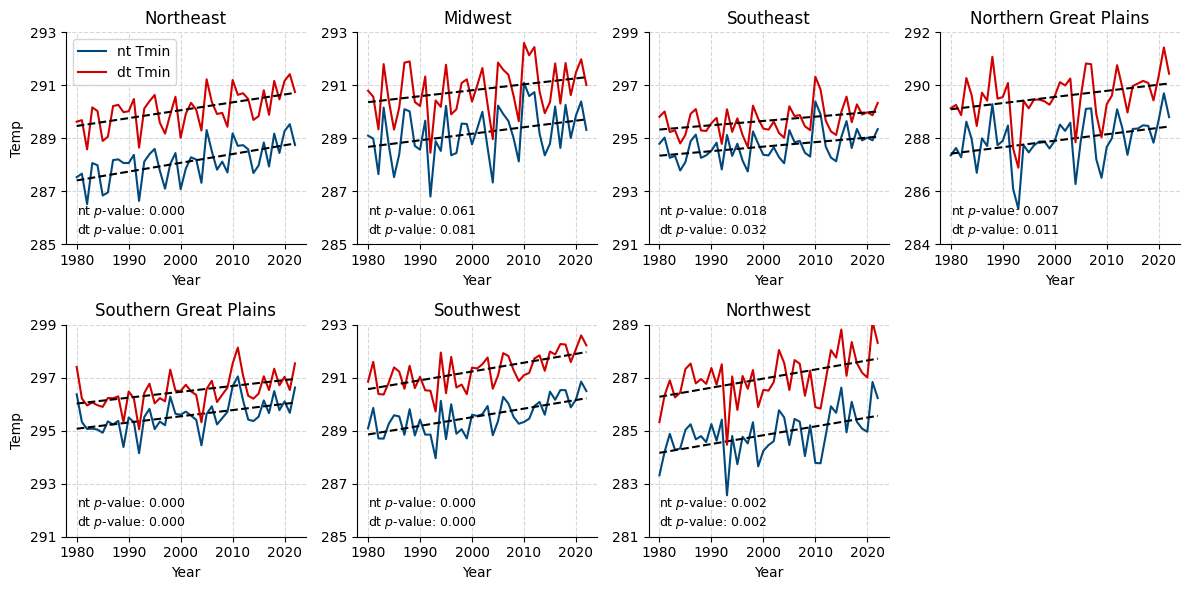

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

x = np.arange(0, 43)

regions_abbr = ['NE', 'Midwest', 'SE', 'NGP', 'SGP', 'SW', 'NW']
regions_name = ['Northeast', 'Midwest', 'Southeast', 'Northern Great Plains', 'Southern Great Plains', 'Southwest', 'Northwest']
custom_ticks = [
    np.arange(285, 295, 2), 
    np.arange(285, 295, 2),  
    np.arange(291, 301, 2), 
    np.arange(284, 294, 2), 
    np.arange(291, 301, 2),  
    np.arange(285, 295, 2),  
    np.arange(281, 291, 2)   
]

fig, axes = plt.subplots(2, 4, figsize=(12, 6), dpi=100)
axes = axes.flatten()

for i, abbr in enumerate(regions_abbr):

    arr_tmin = arr_results_tmin[f'arr_{abbr}_tmin']
    arr_dt_tmin = arr_results_dt_tmin[f'arr_{abbr}_dt_tmin']

    tau_tmin, p_value_tmin = kendalltau(x, arr_tmin)
    coeffs_tmin = np.polyfit(x, arr_tmin, 1)
    trendline_tmin = np.polyval(coeffs_tmin, x)
    
    tau_dt_tmin, p_value_dt_tmin = kendalltau(x, arr_dt_tmin)
    coeffs_dt_tmin = np.polyfit(x, arr_dt_tmin, 1)
    trendline_dt_tmin = np.polyval(coeffs_dt_tmin, x)

    axes[i].plot(x, arr_tmin, label='nt Tmin', color='#01497c')
    axes[i].plot(x, trendline_tmin, linestyle='--', color='k')


    axes[i].plot(x, arr_dt_tmin, label='dt Tmin', color='#d00000')
    axes[i].plot(x, trendline_dt_tmin,  linestyle='--', color='k')

    axes[i].set_title(f'{regions_name[i]}')
    axes[i].set_xlabel('Year')
    axes[i].set_xticks([0, 10, 20, 30, 40])
    axes[i].set_xticklabels([1980, 1990, 2000, 2010, 2020])

    axes[i].set_ylim(custom_ticks[i][0], custom_ticks[i][-1])
    axes[i].set_yticks(custom_ticks[i])

    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].grid(True, ls='--', alpha=0.5)

    axes[i].text(x[0], custom_ticks[i][0] + 0.2, f'nt $p$-value: {p_value_tmin:.3f}\ndt $p$-value: {p_value_dt_tmin:.3f}', 
                 fontsize=9, color='black', ha='left', va='bottom')

    if i in [0, 4]:
        axes[i].set_ylabel('Temp')

axes[0].legend(prop={'size': 10})
axes[7].axis('off') 

plt.tight_layout()
plt.show()


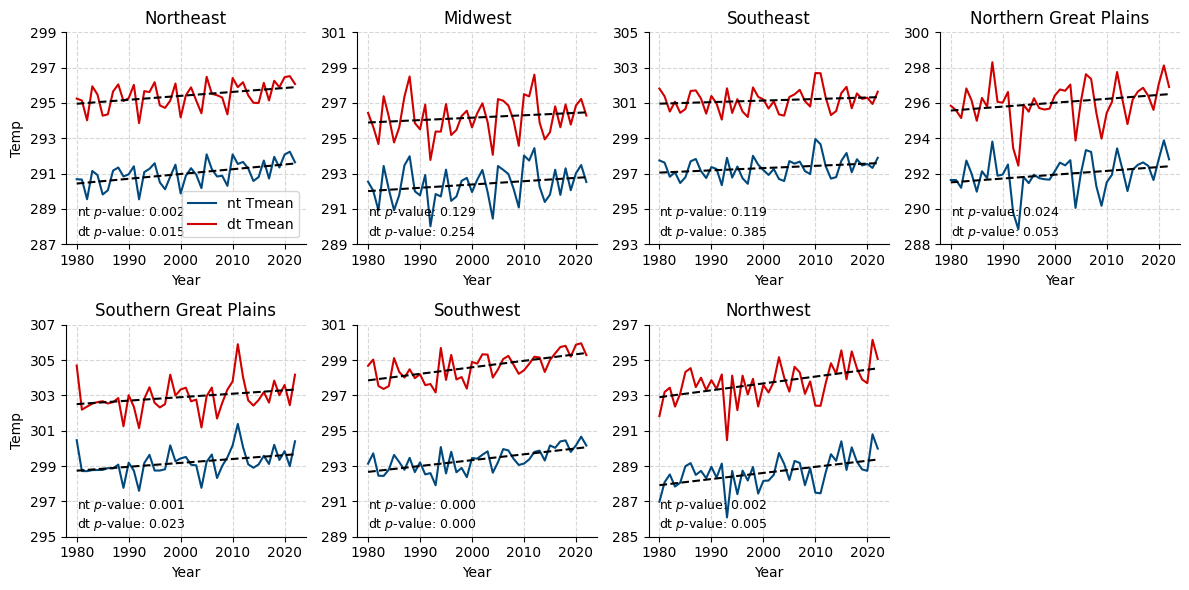

In [91]:

x = np.arange(0, 43)

regions_abbr = ['NE', 'Midwest', 'SE', 'NGP', 'SGP', 'SW', 'NW']
regions_name = ['Northeast', 'Midwest', 'Southeast', 'Northern Great Plains', 'Southern Great Plains', 'Southwest', 'Northwest']
custom_ticks = [
    np.arange(287, 301, 2), 
    np.arange(289, 303, 2),  
    np.arange(293, 307, 2), 
    np.arange(288, 302, 2), 
    np.arange(295, 309, 2),  
    np.arange(289, 303, 2),  
    np.arange(285, 299, 2)   
]

fig, axes = plt.subplots(2, 4, figsize=(12, 6), dpi=100)
axes = axes.flatten()

for i, abbr in enumerate(regions_abbr):

    arr_tmean = arr_results_tmean[f'arr_{abbr}_tmean']
    arr_dt_tmean = arr_results_dt_tmean[f'arr_{abbr}_dt_tmean']

    tau_tmean, p_value_tmean = kendalltau(x, arr_tmean)
    coeffs_tmean = np.polyfit(x, arr_tmean, 1)
    trendline_tmean = np.polyval(coeffs_tmean, x)
    
    tau_dt_tmean, p_value_dt_tmean = kendalltau(x, arr_dt_tmean)
    coeffs_dt_tmean = np.polyfit(x, arr_dt_tmean, 1)
    trendline_dt_tmean = np.polyval(coeffs_dt_tmean, x)

    axes[i].plot(x, arr_tmean, label='nt Tmean', color='#01497c')
    axes[i].plot(x, trendline_tmean, linestyle='--', color='k')


    axes[i].plot(x, arr_dt_tmean, label='dt Tmean', color='#d00000')
    axes[i].plot(x, trendline_dt_tmean, linestyle='--', color='k')

    axes[i].set_title(f'{regions_name[i]}')
    axes[i].set_xlabel('Year')
    axes[i].set_xticks([0, 10, 20, 30, 40])
    axes[i].set_xticklabels([1980, 1990, 2000, 2010, 2020])

    axes[i].set_ylim(custom_ticks[i][0], custom_ticks[i][-1])
    axes[i].set_yticks(custom_ticks[i])

    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].grid(True, ls='--', alpha=0.5)

    axes[i].text(x[0], custom_ticks[i][0] + 0.2, f'nt $p$-value: {p_value_tmean:.3f}\ndt $p$-value: {p_value_dt_tmean:.3f}', 
                 fontsize=9, color='black', ha='left', va='bottom')

    if i in [0, 4]:
        axes[i].set_ylabel('Temp')

axes[0].legend(prop={'size': 10})
axes[7].axis('off') 

plt.tight_layout()
plt.show()

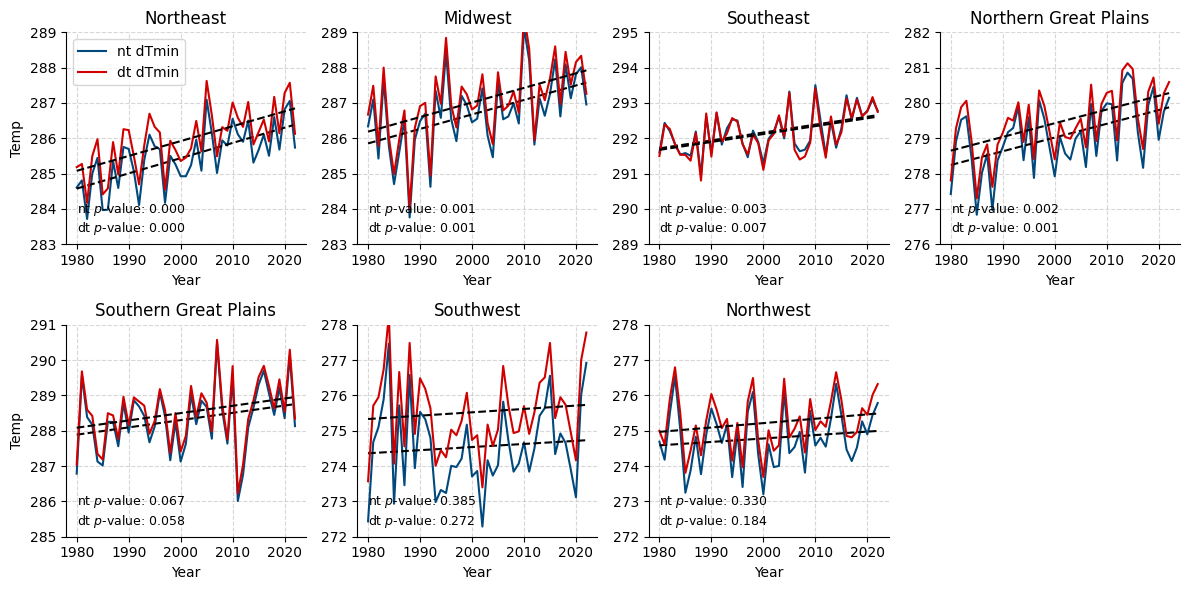

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

x = np.arange(0, 43)

regions_abbr = ['NE', 'Midwest', 'SE', 'NGP', 'SGP', 'SW', 'NW']
regions_name = ['Northeast', 'Midwest', 'Southeast', 'Northern Great Plains', 'Southern Great Plains', 'Southwest', 'Northwest']
custom_ticks = [
    np.arange(283, 290), 
    np.arange(283, 290),  
    np.arange(289, 296), 
    np.arange(276, 283), 
    np.arange(285, 292),  
    np.arange(272, 279),  
    np.arange(272, 279)   
]


fig, axes = plt.subplots(2, 4, figsize=(12, 6), dpi=100)
axes = axes.flatten()

for i, abbr in enumerate(regions_abbr):

    arr_dtmin = arr_results_dtmin[f'arr_{abbr}_dtmin']
    arr_dt_dtmin = arr_results_dt_dtmin[f'arr_{abbr}_dt_dtmin']

    tau_dtmin, p_value_dtmin = kendalltau(x, arr_dtmin)
    coeffs_dtmin = np.polyfit(x, arr_dtmin, 1)
    trendline_dtmin = np.polyval(coeffs_dtmin, x)
    
    tau_dt_dtmin, p_value_dt_dtmin = kendalltau(x, arr_dt_dtmin)
    coeffs_dt_dtmin = np.polyfit(x, arr_dt_dtmin, 1)
    trendline_dt_dtmin = np.polyval(coeffs_dt_dtmin, x)

    axes[i].plot(x, arr_dtmin, label='nt dTmin', color='#01497c')
    axes[i].plot(x, trendline_dtmin,  linestyle='--', color='k')


    axes[i].plot(x, arr_dt_dtmin, label='dt dTmin', color='#d00000')
    axes[i].plot(x, trendline_dt_dtmin, linestyle='--', color='k')

    axes[i].set_title(f'{regions_name[i]}')
    axes[i].set_xlabel('Year')
    axes[i].set_xticks([0, 10, 20, 30, 40])
    axes[i].set_xticklabels([1980, 1990, 2000, 2010, 2020])

    axes[i].set_ylim(custom_ticks[i][0], custom_ticks[i][-1])
    axes[i].set_yticks(custom_ticks[i])

    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].grid(True, ls='--', alpha=0.5)

    axes[i].text(x[0], custom_ticks[i][0] + 0.2, f'nt $p$-value: {p_value_dtmin:.3f}\ndt $p$-value: {p_value_dt_dtmin:.3f}', 
                 fontsize=9, color='black', ha='left', va='bottom')

    if i in [0, 4]:
        axes[i].set_ylabel('Temp')

axes[0].legend(prop={'size': 10})
axes[7].axis('off') 

plt.tight_layout()
plt.show()

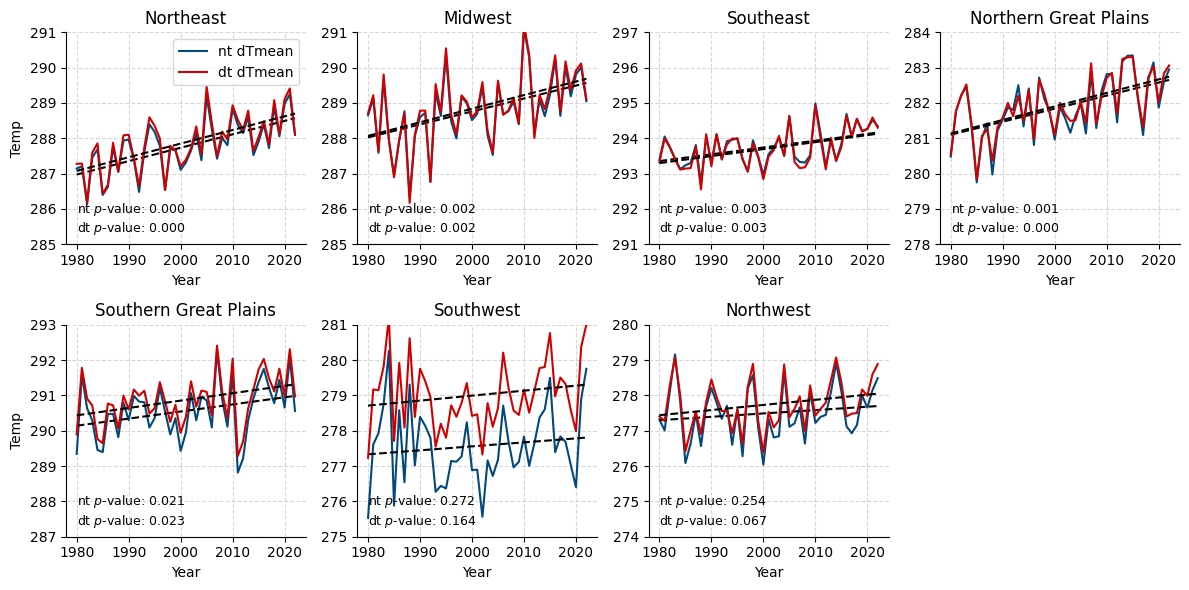

In [93]:

x = np.arange(0, 43)

regions_abbr = ['NE', 'Midwest', 'SE', 'NGP', 'SGP', 'SW', 'NW']
regions_name = ['Northeast', 'Midwest', 'Southeast', 'Northern Great Plains', 'Southern Great Plains', 'Southwest', 'Northwest']
custom_ticks = [
    np.arange(285, 292), 
    np.arange(285, 292),  
    np.arange(291, 298), 
    np.arange(278, 285), 
    np.arange(287, 294),  
    np.arange(275, 282),  
    np.arange(274, 281)   
]

fig, axes = plt.subplots(2, 4, figsize=(12, 6), dpi=100)
axes = axes.flatten()

for i, abbr in enumerate(regions_abbr):

    arr_dtmean = arr_results_dtmean[f'arr_{abbr}_dtmean']
    arr_dt_dtmean = arr_results_dt_dtmean[f'arr_{abbr}_dt_dtmean']

    tau_dtmean, p_value_dtmean = kendalltau(x, arr_dtmean)
    coeffs_dtmean = np.polyfit(x, arr_dtmean, 1)
    trendline_dtmean = np.polyval(coeffs_dtmean, x)
    
    tau_dt_dtmean, p_value_dt_dtmean = kendalltau(x, arr_dt_dtmean)
    coeffs_dt_dtmean = np.polyfit(x, arr_dt_dtmean, 1)
    trendline_dt_dtmean = np.polyval(coeffs_dt_dtmean, x)

    axes[i].plot(x, arr_dtmean, label='nt dTmean', color='#01497c')
    axes[i].plot(x, trendline_dtmean, linestyle='--', color='k')


    axes[i].plot(x, arr_dt_dtmean, label='dt dTmean', color='#d00000')
    axes[i].plot(x, trendline_dt_dtmean,  linestyle='--', color='k')

    axes[i].set_title(f'{regions_name[i]}')
    axes[i].set_xlabel('Year')
    axes[i].set_xticks([0, 10, 20, 30, 40])
    axes[i].set_xticklabels([1980, 1990, 2000, 2010, 2020])

    axes[i].set_ylim(custom_ticks[i][0], custom_ticks[i][-1])
    axes[i].set_yticks(custom_ticks[i])

    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].grid(True, ls='--', alpha=0.5)

    axes[i].text(x[0], custom_ticks[i][0] + 0.2, f'nt $p$-value: {p_value_dtmean:.3f}\ndt $p$-value: {p_value_dt_dtmean:.3f}', 
                 fontsize=9, color='black', ha='left', va='bottom')

    if i in [0, 4]:
        axes[i].set_ylabel('Temp')

axes[0].legend(prop={'size': 10})
axes[7].axis('off') 

plt.tight_layout()
plt.show()

### nighttime temp trend

In [56]:
arr_tmin = ds_tmin.t.values
arr_tmean = ds_tmean.t.values
arr_dtmin = ds_dtmin.dt.values
arr_dtmean = ds_dtmean.dt.values

In [86]:
import numpy as np
import pymannkendall as mk  # Make sure you have the pymannkendall library

# Create a list of the arrays to process
arrays = {
    'Tmin': arr_tmin,
    'Tmean': arr_tmean,
    'dTmin': arr_dtmin,
    'dTmean': arr_dtmean,
}

# Initialize dictionaries to store results
arr_trends = {}
arr_pvalues = {}
arr_slopes = {}

# Loop through each array in the dictionary
for key, arr in arrays.items():
    # Create empty arrays to store the results for each key
    arr_trends[key] = np.empty((arr.shape[1], arr.shape[2]), dtype=object)  # For trend results
    arr_pvalues[key] = np.empty((arr.shape[1], arr.shape[2]))  # For p-values
    arr_slopes[key] = np.empty((arr.shape[1], arr.shape[2]))  # For slopes
    
    for i in range(arr.shape[1]):
        for j in range(arr.shape[2]):
            # Remove NaN values
            mask = ~np.isnan(arr[:, i, j])
            y_clean = arr[:, i, j][mask]
            
            # Perform Mann-Kendall test if there's enough data
            if len(y_clean) > 1:  # At least two data points are needed for the test
                result = mk.original_test(y_clean)
                trend = result.trend
                p_value = result.p
                slope = result.slope
            else:
                trend, p_value, slope = np.nan, np.nan, np.nan  # Set to NaN if insufficient data
            
            # Store the results in the respective arrays
            arr_trends[key][i, j] = trend
            arr_pvalues[key][i, j] = p_value
            arr_slopes[key][i, j] = slope

In [87]:
arr_tr_replaced = {}

# Loop through each key in the arr_trends dictionary
for key in arr_trends.keys():
    # Replace 'no trend' with 0.0, 'increasing' with 1.0, and 'decreasing' with -1.0
    arr_tr_replaced[key] = np.where(arr_trends[key] == 'no trend', 0.0,
                                     np.where(arr_trends[key] == 'increasing', 1.0,
                                              np.where(arr_trends[key] == 'decreasing', -1.0, arr_trends[key]))).astype(float)

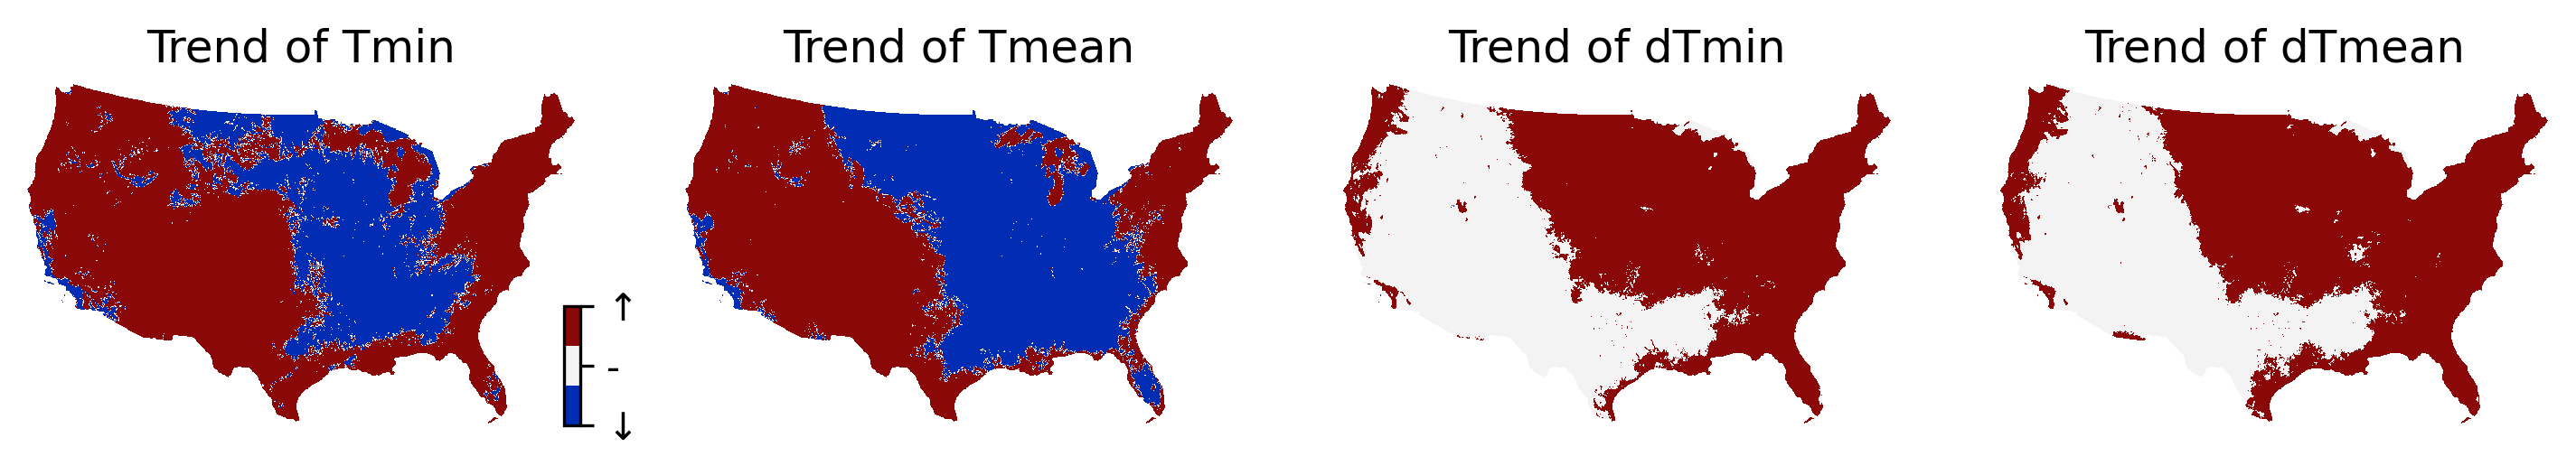

In [88]:
clist1=['#035a96','#1079c3','#3d9fee','#ffffff','#ff6d6d','#f26ca7','#920efc']
cmap1 = LinearSegmentedColormap.from_list('chaos',clist1)
clist2=['#002db3','#f3f3f3','#8a0808']
cmap2 = ListedColormap(clist2)

import matplotlib.patches as patches
titles = [ 'Trend of Tmin', 'Trend of Tmean','Trend of dTmin','Trend of dTmean',]


# Create a (2x2) subplot grid
fig, ax = plt.subplots(1, 4, figsize=(12, 2), dpi=300)

# Plot each array in its respective subplot
arrays_ep_trend = [arr_tr_replaced['Tmin'], arr_tr_replaced['Tmean'], arr_tr_replaced['dTmin'],arr_tr_replaced['dTmean'],]
for i, axi in enumerate(ax.flat):
    im = axi.imshow(np.flip(arrays_ep_trend[i], axis=0), cmap=cmap2)
    axi.set_title(titles[i])
    axi.set_xticks([])
    axi.set_yticks([])
    axi.spines['top'].set_visible(False)
    axi.spines['bottom'].set_visible(False)
    axi.spines['left'].set_visible(False)
    axi.spines['right'].set_visible(False)
        # Add a single set of colored circles to each subplot

cax1 = fig.add_axes([0.29, 0.18, 0.005, 0.22])
cbar = fig.colorbar(im, cax=cax1, )

im.set_clim(vmin=-1, vmax=1)
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['↓', '-', '↑'])
cbar.set_label('')

plt.show()

In [89]:
arrays_ep_pvalues = [arr_pvalues['Tmin'], arr_pvalues['Tmean'], arr_pvalues['dTmin'], arr_pvalues['dTmean']]

# Create an empty list to store the modified arrays
arr_p05 = []

# Loop through each array in arrays_ep_pvalues
for arr in arrays_ep_pvalues:
    # Use np.where to replace values greater than 0.05 with np.nan
    modified_arr = np.where(arr > 0.05, np.nan, arr)
    arr_p05.append(modified_arr)  # Append the modified array to the new list

# If you want to convert it back to a dictionary, you can use this:
arr_p05_dict = {
    'Tmin': arr_p05[0],
    'Tmean': arr_p05[1],
    'dTmin': arr_p05[2],
    'dTmean': arr_p05[3],
}

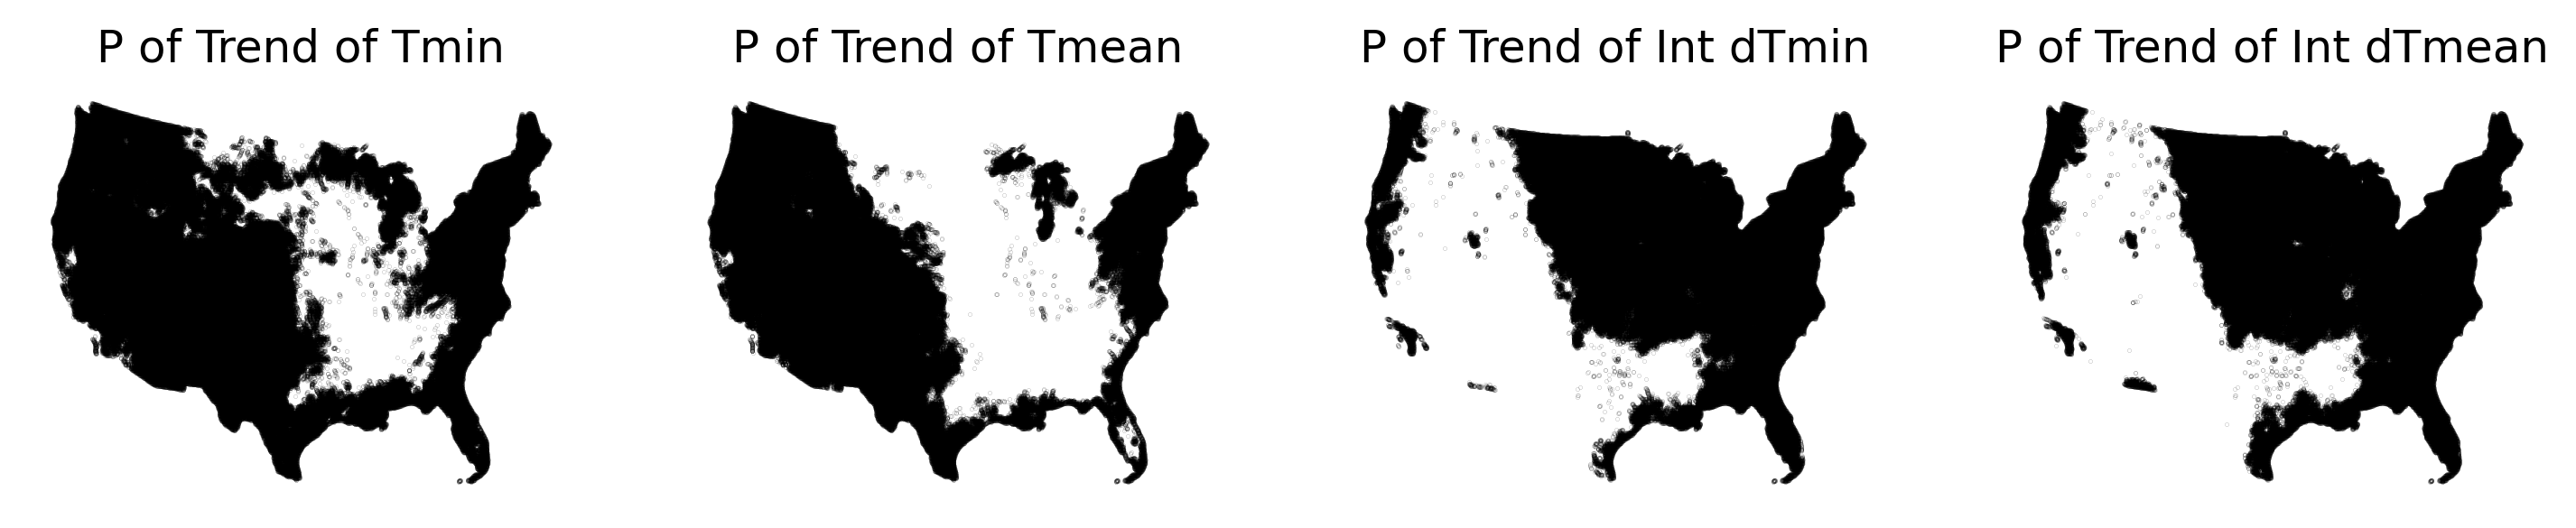

In [90]:
titles = [ 'P of Trend of Tmin', 'P of Trend of Tmean', 'P of Trend of Int dTmin', 'P of Trend of Int dTmean',]

# Create a (2x2) subplot grid
fig, ax = plt.subplots(1, 4, figsize=(12, 2), dpi=300)

# Plot each array in its respective subplot
arrays_ep_pvalues = [arr_p05_dict['Tmin'], arr_p05_dict['Tmean'], arr_p05_dict['dTmin'], arr_p05_dict['dTmean'],]
for i, axi in enumerate(ax.flat):
    y, x = np.where(~np.isnan(arrays_ep_pvalues[i]))
    im = axi.scatter(x, y, s=0.001, color='k')
    axi.set_title(titles[i])
    axi.set_xticks([])
    axi.set_yticks([])
    axi.spines['top'].set_visible(False)
    axi.spines['bottom'].set_visible(False)
    axi.spines['left'].set_visible(False)
    axi.spines['right'].set_visible(False)

plt.show()

###  daytime temp trend 

In [94]:
arr_tmin = ds_dt_tmin.t.values
arr_tmean = ds_dt_tmean.t.values
arr_dtmin = ds_dt_dtmin.dt.values
arr_dtmean = ds_dt_dtmean.dt.values

In [95]:
import numpy as np
import pymannkendall as mk  # Make sure you have the pymannkendall library

# Create a list of the arrays to process
arrays = {
    'Tmin': arr_tmin,
    'Tmean': arr_tmean,
    'dTmin': arr_dtmin,
    'dTmean': arr_dtmean,
}

# Initialize dictionaries to store results
arr_trends = {}
arr_pvalues = {}
arr_slopes = {}

# Loop through each array in the dictionary
for key, arr in arrays.items():
    # Create empty arrays to store the results for each key
    arr_trends[key] = np.empty((arr.shape[1], arr.shape[2]), dtype=object)  # For trend results
    arr_pvalues[key] = np.empty((arr.shape[1], arr.shape[2]))  # For p-values
    arr_slopes[key] = np.empty((arr.shape[1], arr.shape[2]))  # For slopes
    
    for i in range(arr.shape[1]):
        for j in range(arr.shape[2]):
            # Remove NaN values
            mask = ~np.isnan(arr[:, i, j])
            y_clean = arr[:, i, j][mask]
            
            # Perform Mann-Kendall test if there's enough data
            if len(y_clean) > 1:  # At least two data points are needed for the test
                result = mk.original_test(y_clean)
                trend = result.trend
                p_value = result.p
                slope = result.slope
            else:
                trend, p_value, slope = np.nan, np.nan, np.nan  # Set to NaN if insufficient data
            
            # Store the results in the respective arrays
            arr_trends[key][i, j] = trend
            arr_pvalues[key][i, j] = p_value
            arr_slopes[key][i, j] = slope

In [96]:
arr_tr_replaced = {}

# Loop through each key in the arr_trends dictionary
for key in arr_trends.keys():
    # Replace 'no trend' with 0.0, 'increasing' with 1.0, and 'decreasing' with -1.0
    arr_tr_replaced[key] = np.where(arr_trends[key] == 'no trend', 0.0,
                                     np.where(arr_trends[key] == 'increasing', 1.0,
                                              np.where(arr_trends[key] == 'decreasing', -1.0, arr_trends[key]))).astype(float)

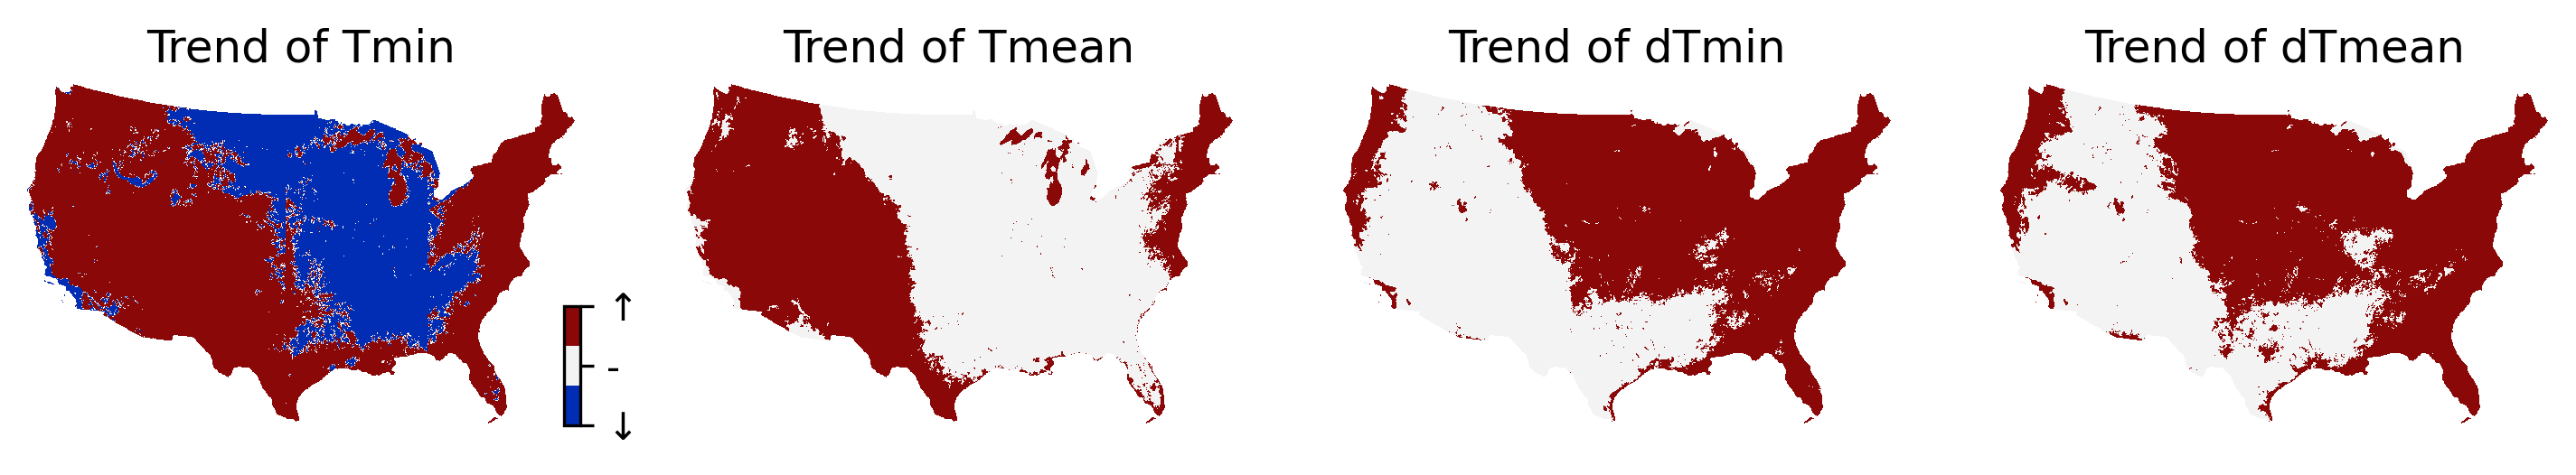

In [97]:
clist1=['#035a96','#1079c3','#3d9fee','#ffffff','#ff6d6d','#f26ca7','#920efc']
cmap1 = LinearSegmentedColormap.from_list('chaos',clist1)
clist2=['#002db3','#f3f3f3','#8a0808']
cmap2 = ListedColormap(clist2)

import matplotlib.patches as patches
titles = [ 'Trend of Tmin', 'Trend of Tmean','Trend of dTmin','Trend of dTmean',]


# Create a (2x2) subplot grid
fig, ax = plt.subplots(1, 4, figsize=(12, 2), dpi=300)

# Plot each array in its respective subplot
arrays_ep_trend = [arr_tr_replaced['Tmin'], arr_tr_replaced['Tmean'], arr_tr_replaced['dTmin'],arr_tr_replaced['dTmean'],]
for i, axi in enumerate(ax.flat):
    im = axi.imshow(np.flip(arrays_ep_trend[i], axis=0), cmap=cmap2)
    axi.set_title(titles[i])
    axi.set_xticks([])
    axi.set_yticks([])
    axi.spines['top'].set_visible(False)
    axi.spines['bottom'].set_visible(False)
    axi.spines['left'].set_visible(False)
    axi.spines['right'].set_visible(False)
        # Add a single set of colored circles to each subplot

cax1 = fig.add_axes([0.29, 0.18, 0.005, 0.22])
cbar = fig.colorbar(im, cax=cax1, )

im.set_clim(vmin=-1, vmax=1)
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['↓', '-', '↑'])
cbar.set_label('')

plt.show()

In [98]:
arrays_ep_pvalues = [arr_pvalues['Tmin'], arr_pvalues['Tmean'], arr_pvalues['dTmin'], arr_pvalues['dTmean']]

# Create an empty list to store the modified arrays
arr_p05 = []

# Loop through each array in arrays_ep_pvalues
for arr in arrays_ep_pvalues:
    # Use np.where to replace values greater than 0.05 with np.nan
    modified_arr = np.where(arr > 0.05, np.nan, arr)
    arr_p05.append(modified_arr)  # Append the modified array to the new list

# If you want to convert it back to a dictionary, you can use this:
arr_p05_dict = {
    'Tmin': arr_p05[0],
    'Tmean': arr_p05[1],
    'dTmin': arr_p05[2],
    'dTmean': arr_p05[3],
}

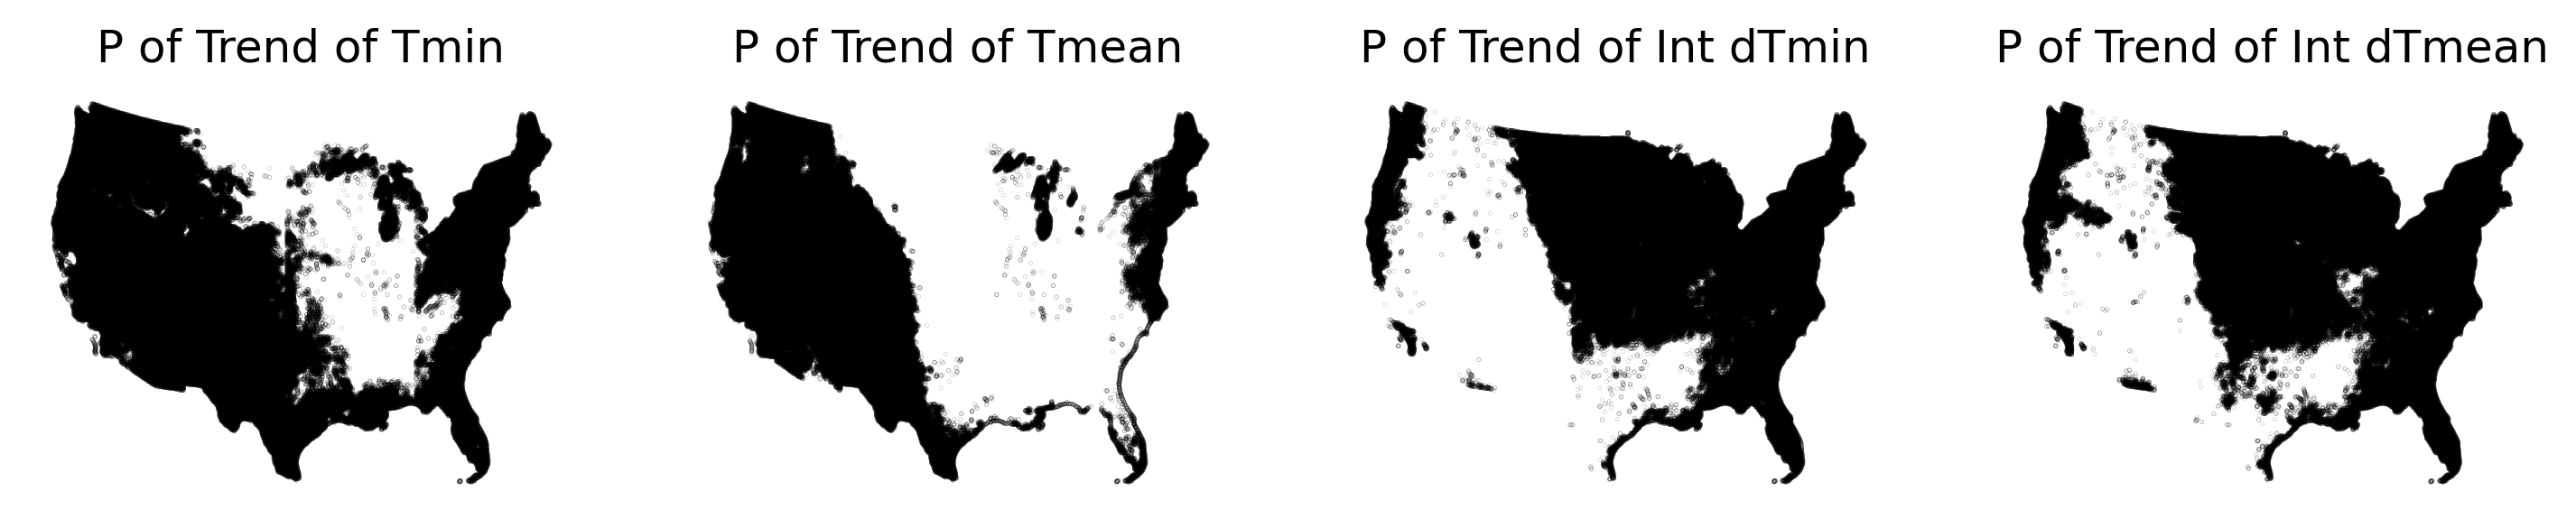

In [99]:
titles = [ 'P of Trend of Tmin', 'P of Trend of Tmean', 'P of Trend of Int dTmin', 'P of Trend of Int dTmean',]

# Create a (2x2) subplot grid
fig, ax = plt.subplots(1, 4, figsize=(12, 2), dpi=300)

# Plot each array in its respective subplot
arrays_ep_pvalues = [arr_p05_dict['Tmin'], arr_p05_dict['Tmean'], arr_p05_dict['dTmin'], arr_p05_dict['dTmean'],]
for i, axi in enumerate(ax.flat):
    y, x = np.where(~np.isnan(arrays_ep_pvalues[i]))
    im = axi.scatter(x, y, s=0.001, color='k')
    axi.set_title(titles[i])
    axi.set_xticks([])
    axi.set_yticks([])
    axi.spines['top'].set_visible(False)
    axi.spines['bottom'].set_visible(False)
    axi.spines['left'].set_visible(False)
    axi.spines['right'].set_visible(False)

plt.show()